[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Neuromorphic Datasets with Tonic + snnTorch
## Tutorial 7
### 강의: [Gregor Lenz](https://lenzgregor.com), [Jason K. Eshraghian](https://www.ncg.ucsc.edu)
### 번역: [ToToKr](https://github.com/MoerAI)
<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/examples/tutorial_7_neuromorphic_datasets.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 튜토리얼 시리즈는 다음 문서를 기반으로 합니다. 이러한 리소스나 코드가 작업에 유용하다고 생각되면 다음 소스를 인용해 주세요:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction
이번 튜토리얼에서 당신은:
* [Tonic](https://github.com/neuromorphs/tonic)을 사용하여 Neuromorphic Datasets을 로드하는 방법에 대해 알아봅니다
* caching을 사용하여 데이터 로딩 속도를 향상시킵니다
* [Neuromorphic-MNIST](https://tonic.readthedocs.io/en/latest/datasets.html#n-mnist) Dataset로 CSNN을 훈련합니다

Google Colab 실행을 하는 경우:
* 다음 메뉴에서 `런타임` > `런타임 유형 변경` > `하드웨어 가속기: GPU`를 확인하여 GPU를 연결합니다.
* 다음 셀을 클릭하고 `Shift+Enter`를 눌러 최신 PyPi 배포판의 snnTorch와 Tonic을 설치합니다.

In [1]:
!pip install tonic --quiet
!pip install snntorch --quiet

# 1. Using Tonic to Load Neuromorphic Datasets
Neuromorphic sensors에서 데이터 세트를 로드하는 것은 PyTorch 비전과 매우 유사하게 작동하는 [Tonic](https://github.com/neuromorphs/tonic) 덕분에 매우 간단해졌습니다.

먼저 [N-MNIST](https://tonic.readthedocs.io/en/latest/reference/datasets.html#n-mnist)라고 하는 Neuromorphic 버전의 MNIST 데이터 집합을 로드해 보겠습니다. 몇 가지 Raw events를 살펴보고 작업중인 내용을 파악할 수 있습니다.

In [2]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1011894272it [05:07, 3289705.76it/s]                                


Extracting ./data\NMNIST\train.zip to ./data\NMNIST
[(10, 30,    937, 1) (33, 20,   1030, 1) (12, 27,   1052, 1) ...
 ( 7, 15, 302706, 1) (26, 11, 303852, 1) (11, 17, 305341, 1)]


각 행은 네 개의 매개변수로 구성된 단일 이벤트에 해당합니다: (*x-coordinate, y-coordinate, timestamp, polarity*).

* x & y co-ordinate는 $34 \times 34$ grid의 주소에 해당합니다.

* 이벤트의 타임스탬프는 microseconds 단위로 기록됩니다.

* 극성(polarity)은 on-spike (+1) 또는 off-spike (-1)가 발생했는지. 즉, 밝기가 증가(on)했는지, 감소(off)했는지를 나타냅니다.

이러한 이벤트를 시간에 따라 누적하여 빈을 이미지로 표시하면 다음과 같이 표시됩니다:

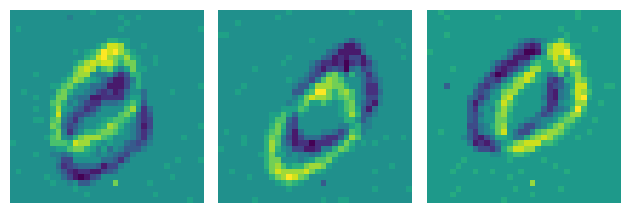

In [3]:
tonic.utils.plot_event_grid(events)

## 1.1 Transformations

그러나 신경망은 event의 list를 input으로 받지 않습니다. Raw data는 반드시 텐서같은 적절한 표현으로 변환되어야 합니다. 데이터를 신경망에 전달하기 전에 데이터에 적용할 변환 세트를 선택할 수 있습니다. Neuromorphic 카메라 센서의 시간 해상도는 마이크로 초 단위이며, 이를 고밀도 표현으로 변환하면 매우 큰 텐서가 됩니다. 그렇기 때문에 시간적 정밀도는 떨어지지만 고밀도 형식으로 작업할 수 있는 [ToFrame 변환](https://tonic.readthedocs.io/en/latest/reference/transformations.html#frames)을 사용하여 이벤트를 더 적은 수의 프레임으로 묶습니다.

* `time_window=1000`은 이벤트를 1000$~\mu$s bins으로 통합합니다.

* 노이즈 제거는 고립된 일회성 이벤트를 제거합니다.`filter_time` microseconds 동안 1픽셀의 인접 영역에서 이벤트가 발생하지 않으면 이벤트가 필터링 됩니다. `filter_time`이 작을수록 더 많은 이벤트를 필터링합니다.

In [4]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

1011894272it [05:36, 3004997.75it/s]                                


Extracting ./tmp/data\NMNIST\train.zip to ./tmp/data\NMNIST


169675776it [00:58, 2896213.46it/s]                               


Extracting ./tmp/data\NMNIST\test.zip to ./tmp/data\NMNIST


In [5]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [6]:
%timeit -o load_sample_simple()

1.6 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.6 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

## 1.2 Fast DataLoading


원본 데이터는 읽기 속도가 느린 형식으로 저장됩니다. 데이터 로딩 속도를 높이기 위해 디스크 캐싱과 일괄 처리를 활용할 수 있습니다. 즉, 원본 데이터 세트에서 파일이 로드되면 디스크에 기록됩니다.

이벤트 녹화의 길이가 서로 다르기 때문에, 일괄 처리의 모든 샘플이 동일한 치수를 갖도록, 짧은 녹화를 패딩하는 collation 함수 `tonic.collation.PadTensors()`를 제공합니다.

In [7]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [8]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [9]:
%timeit -o -r 10 load_sample_batched()

4.48 ms ± 157 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 4.48 ms ± 157 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

디스크 캐싱과 멀티스레딩 및 일괄 처리를 지원하는 PyTorch 데이터로더를 사용하여 로딩 시간을 크게 단축했습니다.

사용 가능한 RAM 용량이 많은 경우 디스크 대신 메인 메모리에 캐싱하여 데이터 로딩 속도를 더욱 높일 수 있습니다:

```
from tonic import MemoryCachedDataset

cached_trainset = MemoryCachedDataset(trainset)
```

# 2. Training our network using frames created from events

이제 실제로 N-MNIST 분류 작업에 대해 네트워크를 훈련시켜 보겠습니다. 먼저 캐싱 래퍼와 데이터 로더를 정의하는 것으로 시작합니다. 이 과정에서 학습 데이터에 몇 가지 증강 기능도 적용할 것입니다. 캐시된 데이터 세트에서 받은 샘플은 프레임이므로 PyTorch Vision을 사용하여 원하는 임의의 변환을 적용할 수 있습니다.

In [10]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

이제 미니 배치에 dimension(time step, batch size, channels, hight, width)가 생겼습니다. Time step 수는 mini batch에서 가장 긴 기록의 time step 수로 설정되며, 다른 모든 샘플은 이에 맞춰 0으로 채워집니다.

In [11]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

torch.Size([311, 128, 2, 34, 34])


## 2.1 Defining our network
이전 튜토리얼에서와 마찬가지로 snnTorch + PyTorch를 사용해 CSNN을 구성하겠습니다. 사용할 컨볼루션 네트워크 아키텍처는 12C5-MP2-32C5-MP2-800FC10입니다.

- 12C5는 12개의 filter와 5 $\times$ 5 컨볼루션 커널 사이즈를 의미합니다. 
- MP2는 2 $\times$ 2 max-pooling 함수입니다.
- 800FC10는 800개의 뉴런을 10개의 output에 매핑하는 fully-connected 레이어입니다.

In [27]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [35]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

## 2.2 Training

이전 튜토리얼에서는 올바른 클래스의 스파이크 수를 최대화하기 위해 총 스파이크 수에 Cross Entropy Loss를 적용했습니다.

`snn.functional` 모듈의 또 다른 옵션은 올바른 클래스와 잘못된 클래스의 목표 스파이크 수를 지정하는 것입니다. 아래 접근방식은 *Mean Square Error Spike Count Loss*을 사용하여 올바른 클래스에서 80\%, 잘못된 클래스에서 20\%의 스파이크를 유도하는 것을 목표로 합니다. 잘못된 뉴런이 발화하도록 장려하면 죽은 뉴런 문제(Dead Neuron Problem)을 피할 수 있습니다.

In [36]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

neuromorphic data를 학습시키는 것은 많은 time step을 순차적으로 반복해야 하므로 비용이 비쌉니다(N-MNIST dataset의 경우 대략 300개의 time step). 다음 시뮬레이션에서는 시간이 다소 걸리므로 50회 반복(전체 epoch의 약 1/10)에 걸쳐 훈련하는 것으로 가정하겠습니다. 시간이 더 필요하다면 ``를 자유롭게 변경할 수 있습니다. 각 반복마다 결과를 인쇄하기 때문에 결과가 상당히 노이즈가 많고 개선 되기까지 어느정도 시간이 걸릴 것입니다.

자체 실험에서는 약 20회의 반복을 거쳐야 개선된 결과를 확인할 수 있었고, 50회 반복 후에는 약 60%의 정확도를 달성할 수 있었습니다..

> 경고: 다음 시뮬레이션은 시간이 오래 걸립니다. 가서 커피나 한 잔 하세요.

In [37]:
num_epochs = 1
num_iters = 60

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # This will end training after 50 iterations by default
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 9.38%

Epoch 0, Iteration 1 
Train Loss: 30.90
Accuracy: 7.03%

Epoch 0, Iteration 2 
Train Loss: 30.90
Accuracy: 10.94%

Epoch 0, Iteration 3 
Train Loss: 30.90
Accuracy: 9.38%

Epoch 0, Iteration 4 
Train Loss: 28.80
Accuracy: 9.38%

Epoch 0, Iteration 5 
Train Loss: 15.00
Accuracy: 10.94%

Epoch 0, Iteration 6 
Train Loss: 15.54
Accuracy: 10.94%

Epoch 0, Iteration 7 
Train Loss: 17.69
Accuracy: 8.59%

Epoch 0, Iteration 8 
Train Loss: 18.31
Accuracy: 10.94%

Epoch 0, Iteration 9 
Train Loss: 17.17
Accuracy: 21.88%

Epoch 0, Iteration 10 
Train Loss: 14.29
Accuracy: 22.66%

Epoch 0, Iteration 11 
Train Loss: 12.44
Accuracy: 21.88%

Epoch 0, Iteration 12 
Train Loss: 15.78
Accuracy: 29.69%

Epoch 0, Iteration 13 
Train Loss: 15.09
Accuracy: 28.91%

Epoch 0, Iteration 14 
Train Loss: 12.13
Accuracy: 32.03%

Epoch 0, Iteration 15 
Train Loss: 12.35
Accuracy: 25.00%

Epoch 0, Iteration 16 
Train Loss: 13.12
Accuracy: 30.47%

Epoch 0, Ite

# 3. Results
## 3.1 Plot Test Accuracy

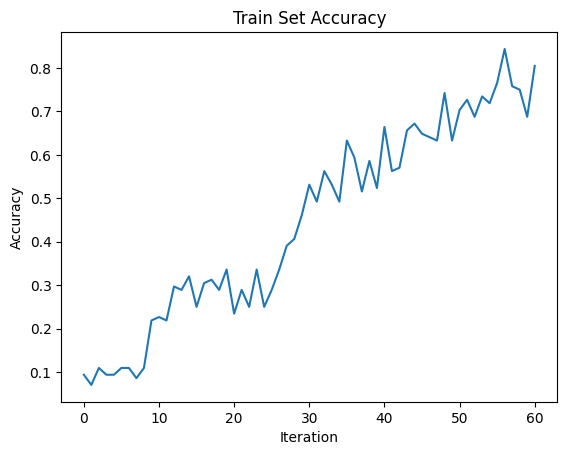

In [38]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## 3.2 Spike Counter

데이터의 batch에 대한 forward pass를 실행하여 스파이크 기록을 얻습니다.

In [39]:
Wspk_rec = forward_pass(net, data)

`idx`를 변경하면 시뮬레이션된 미니배치에서 다양한 샘플로 인덱싱할 수 있습니다. `splt.spike_count`를 사용하여 몇 가지 다른 샘플의 스파이크 동작을 살펴봅니다. 다음 애니메이션을 생성하는 데 시간이 다소 걸립니다.

> 참고: 데스크톱에서 로컬로 노트북을 실행하는 경우, 아래 줄의 주석 처리를 해제하고 ffmpeg.exe의 경로를 수정하세요.



The target label is: 7


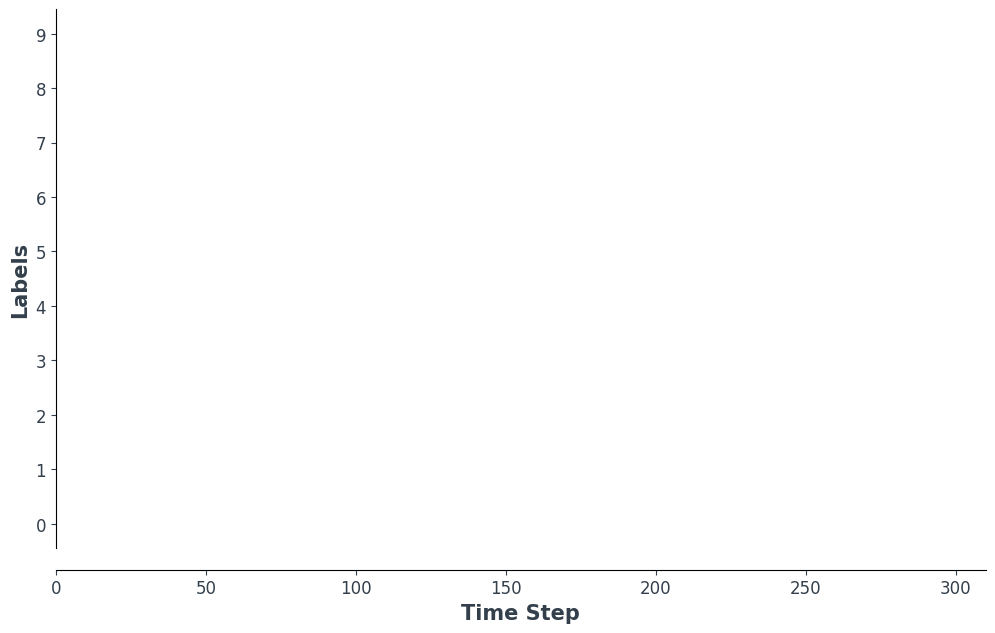

In [40]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# Conclusion
여기까지 읽으셨다면 축하합니다!! - 당신은 수도자의 인내심을 획득하셨습니다. 이제 Tonic을 사용하여 neuromorphic datasets를 로드한 다음 snnTorch를 사용하여 네트워크를 훈련하는 방법도 이해하셨을 것입니다.

이것으로 deep-dive 튜토리얼 시리즈를 마칩니다.
SNN의 장기 시간 역학 도입, 모집단 코딩, 인텔리전스 처리 장츠에서의 가속 등 고급 기술을 배우려면 [advanced tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)을 참조하세요.

이 프로젝트가 마음에 드신다면 GitHub에서 리포지토리의 ⭐(Star)를 눌러주세요.

# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [The Tonic GitHub project can be found here.](https://github.com/neuromorphs/tonic)
* The N-MNIST Dataset was originally published in the following paper: [Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.  “Converting Static Image Datasets to Spiking Neuromorphic Datasets Using Saccades", Frontiers in Neuroscience, vol.9, no.437, Oct. 2015.](https://www.frontiersin.org/articles/10.3389/fnins.2015.00437/full)
* For further information about how N-MNIST was created, please refer to [Garrick Orchard's website here.](https://www.garrickorchard.com/datasets/n-mnist)